In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from multiprocessing import Pool
from lampe.data import JointLoader
from itertools import islice
from tqdm import tqdm
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import coverage_plot

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors

In [3]:
file_name = "23_03_09_results"  # File name
data_dir = "raw_data/"
plot_dir = "plots/"
num_samples_stats = 2000  # Number of simulations for computing posterior stats
num_samples_SBC = 1000  # Number of simulations for SBC
num_posterior_samples_SBC = 4096  # Number of posterior samples for each SBC simulation
num_samples_posterior = 5000  # Number of samples to draw from posterior
batch_size_sampling = 100  # Batch size for sampling posterior
num_workers = 24  # Number of CPU cores
device = "cuda"  # Device for computations
save_figures = False

## Load cryo-em simulator and posterior with correct config

In [4]:
cryosbi = CryoEmSimulator("image_params_snr01_128.json")

hsp90_models.npy


/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /dev/shm/nix-build-py-torch-1.11.0.drv-0/nixbld1/spack-stage-py-torch-1.11.0-1nz745m2yd6q5pzmdri0jhmiqb7dl200/spack-src/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/mnt/ceph/users/dsilvasanchez/projects/new_sbi/cryo_em_SBI/src/cryo_sbi/wpa_simulator/ctf.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
/mnt/ceph/users/dsilvasanchez/projects/new_sbi/cryo_em_SBI/src/cryo_sbi/wpa_simulator/ctf.py:38: UserWarning: To copy construct from a tensor, 

In [5]:
train_config = json.load(open("resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load("resnet18_encoder_snr01.estimator"))
estimator.cuda()
estimator.eval();

## Testing posterior on single images

In [6]:
indices = torch.tensor(np.arange(0, cryosbi.max_index + 1, 1), dtype=float)

In [7]:
images = []
quats = []

for index in indices:
    image, quat = cryosbi.simulator(index)
    images.append(image)
    quats.append(torch.tensor(quat))

images = torch.stack(images, dim=0)
quats = torch.stack(quats)

In [19]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(
        images, split_size_or_sections=batch_size_sampling, dim=0
    ):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True), shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(samples)
    samples = torch.cat(theta_samples, dim=1)

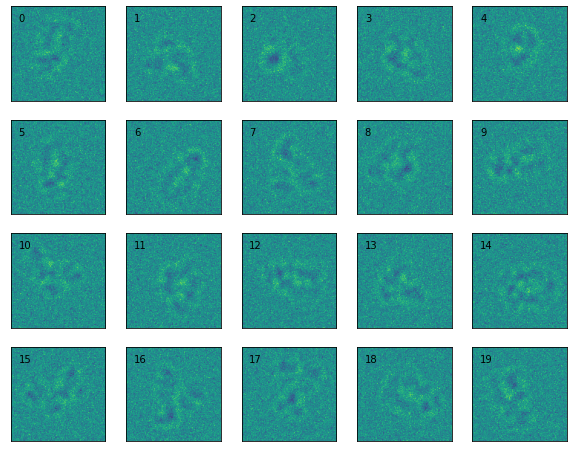

In [20]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[idx], vmax=5, vmin=-5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(10, 20, str(int(indices[idx].item())))

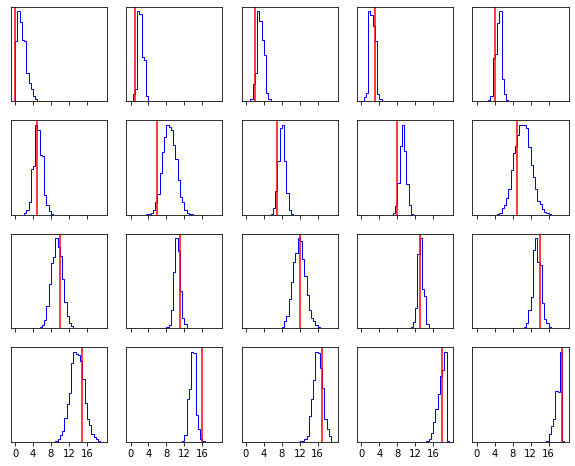

In [21]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples[:, idx].numpy(),
        bins=np.arange(0, 20, 0.5),
        histtype="step",
        color="blue",
        label="all",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 20, 4))
    ax.axvline(indices[idx], color="red")

## Generate images from prior and evaluate posterior for statistical analysis

In [15]:
indices = priors.get_uniform_prior_1d(cryosbi.max_index).sample((num_samples_stats,))
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [16]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(
        images, split_size_or_sections=batch_size_sampling, dim=0
    ):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True), shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(samples.reshape(-1, batch_size_sampling))
    samples = torch.cat(theta_samples, dim=1)

In [17]:
mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

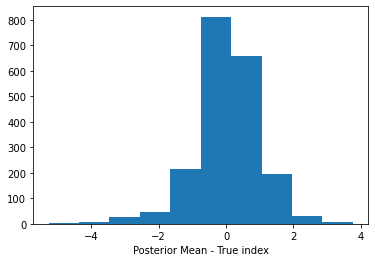

In [19]:
_ = plt.hist(mean_distance)
_ = plt.xlabel("Posterior Mean - True index")

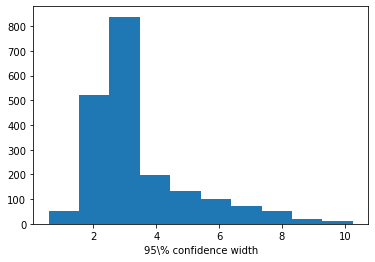

In [20]:
_ = plt.hist(confidence_widths)
_ = plt.xlabel("95\% confidence width")

## Compute posterior calibration

1000pair [00:29, 33.43pair/s]


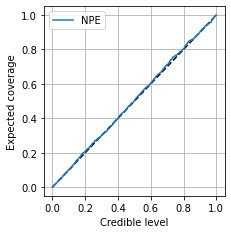

In [22]:
loader = JointLoader(
    priors.get_uniform_prior_1d(cryosbi.max_index),
    cryosbi.simulator,
    vectorized=False,
    batch_size=1,
    num_workers=num_workers,
    prefetch_factor=1,
)

levels, coverages = expected_coverage_mc(
    estimator.flow,
    (
        (estimator.standardize(theta.cuda()), x.cuda())
        for theta, x in islice(loader, num_samples_SBC)
    ),
    n=num_posterior_samples_SBC,
)

fig = coverage_plot(levels, coverages, legend="NPE")

if save_figures:
    fig.savefig(f"{plot_dir}{file_name}_SBC.pdf", dpi=400)

## Generate images from index 10 with known quaternion

In [27]:
quats = torch.from_numpy(np.load("quaternion_list.npy"))[:5000]
num_simulations = len(quats)
indices = 10 * torch.ones(num_simulations).reshape(-1, 1)
parameters = torch.cat((indices, quats), dim=1)
images = torch.stack(
    [cryosbi._simulator_with_quat(param) for param in parameters], dim=0
)

In [28]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(
        images, split_size_or_sections=batch_size_sampling, dim=0
    ):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True), shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(samples.reshape(-1, batch_size_sampling))
samples = torch.cat(theta_samples, dim=1)

In [29]:
mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

/tmp/ipykernel_49433/3633206100.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


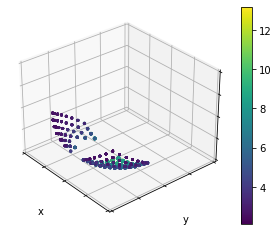

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.transform import Rotation

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0 : 2.0 * pi : 100j]
x = r * sin(phi) * cos(theta)
y = r * sin(phi) * sin(theta)
z = r * cos(phi)

unit_vecotr = np.array([0, 0, 1])
points = []
for i in range(len(quats)):
    rot_mat = Rotation.from_quat(quats[i]).as_matrix()
    coord = np.matmul(rot_mat, unit_vecotr)
    points.append(coord)
points = np.array(points)

xx = points[:, 0]
yy = points[:, 1]
zz = points[:, 2]

# Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# ax.plot_surface(
#    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

im = ax.scatter(xx, yy, zz, s=confidence_widths, c=confidence_widths)

ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.set_zlabel('z')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.azim = -40
ax.elev = 30
ax.dist = 10

fig.colorbar(im)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_aspect("auto")
plt.tight_layout()
plt.show()